In [1]:
import numpy as np
import scipy.sparse as sp
from sklearn.utils.extmath import randomized_svd

### Generowanie macierzy rzadkich

In [2]:
def sparse_matrix(rows, cols, density):
    return sp.rand(rows, cols, density=density).toarray()

### Klasa węzła

In [3]:
class CompressNode:
    def __init__(self, rank=0, children=None, singular_values=None, U=None, V=None, size=None):
        self.rank = rank
        self.children = children
        self.s = singular_values
        self.U = U
        self.V = V
        self.size = size
        self.val = None
        
    def append_child(self, child):
        self.children.append(child)
    
    def __str__(self):
        return f'Node: rank = {self.rank}; children: {self.children}; s: {self.s}; U = {self.U}; V = {self.V}, size = {self.size}'

### Kompresja

In [4]:
def compress_matrix(matrix, U, s, V, r):
    node = None
    if (matrix == 0).all():
        node = CompressNode(rank=0, size=matrix.shape)
    
    else:
        D = np.diag(s)
        node = CompressNode(rank=r, singular_values=s[:r], U=U[:, :r], V=D[:r, :r] @ V[:r, ], 
                            size=matrix.shape)
    
    return node

In [5]:
def create_tree(matrix, r, epsilon):
    U, s, V = randomized_svd(matrix, n_components=r)
    r = s.size
    node = None
    if s[-1] < epsilon:
        node = compress_matrix(matrix, U, s, V, r)
    
    else:
        Y, X = matrix.shape
        
        if Y == X == 1:
            node = CompressNode(rank=1, size=(1, 1))
            node.val = matrix
            return node
        
        node = CompressNode(rank=r, children=[], size=(Y, X))
        
        # 4 childrens
        
        node.append_child(create_tree(matrix[0: Y // 2, 0: X // 2], r, epsilon))
        node.append_child(create_tree(matrix[0: Y // 2, X // 2: X], r, epsilon))
        node.append_child(create_tree(matrix[Y // 2: Y, 0: X // 2], r, epsilon))
        node.append_child(create_tree(matrix[Y // 2: Y, X // 2: X], r, epsilon))
        
    return node


### Dekompresja

In [6]:
def decompression(root):
    if root.U is None and root.V is None and root.rank == 0: # Only zeros
        return np.zeros(root.size)
    
    elif root.children is None: # Leaf
        if root.val is not None: # Leaf
            return root.val
        return root.U @ root.V # maybe @singular_values, but I think it has already done
    
    else:
        children_dec = [decompression(child) for child in root.children]
        
        
        return np.vstack((np.hstack((children_dec[0], children_dec[1])),
                        np.hstack((children_dec[2], children_dec[3]))))    

### Różnica

In [7]:
def diff(original, decompressed):
    return np.sum(np.square(original - decompressed))

### Visualizer

In [11]:
import matplotlib.pyplot as plt
import scipy.sparse as sp

def _canvas_matrix(root, x, y, n): #n must be 2^i where i is natural number
    if root.U is None and root.V is None and root.rank == 0: # Only zeros
        return
    
    elif root.children is None: # Leaf
        if root.val is not None: # Leaf
            plt.scatter(x, y, color="red", s=0.1)
            return
        else:
            xe = x + root.size[1]
            ye = y + root.size[0]
            plt.plot([x, xe], [y, y], color="black", lw=root.rank)
            plt.plot([x, x], [y, ye], color="black", lw=root.rank)
            return
    
    else:
        childs = root.children
        n = n//2
        _canvas_matrix(childs[0], x, y + n, n)
        _canvas_matrix(childs[1], x + n, y + n, n)
        _canvas_matrix(childs[2], x, y, n)
        _canvas_matrix(childs[3], x + n, y, n)
        return

def wisualize_svd(matrix_tree: CompressNode, n):
    _canvas_matrix(matrix_tree, 0,0, n)

### Przykład urzycia

In [102]:
matrix = sparse_matrix(8, 8, 0.5)
matrix

array([[0.02628156, 0.94817461, 0.        , 0.        , 0.98121427,
        0.87260987, 0.        , 0.        ],
       [0.56796912, 0.15921753, 0.25137726, 0.84586507, 0.        ,
        0.07221024, 0.96127665, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.43768431,
        0.59489708, 0.        , 0.9611029 ],
       [0.        , 0.        , 0.79105006, 0.73315715, 0.        ,
        0.        , 0.        , 0.71378228],
       [0.08018712, 0.82755834, 0.32077907, 0.        , 0.        ,
        0.        , 0.        , 0.0043637 ],
       [0.94621468, 0.64842067, 0.        , 0.32991965, 0.79678239,
        0.        , 0.37016821, 0.59333952],
       [0.        , 0.21000804, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.38792221],
       [0.51672689, 0.9397816 , 0.        , 0.7100157 , 0.        ,
        0.        , 0.        , 0.03382638]])

In [103]:
compressed = create_tree(matrix, r=2, epsilon=10*-12)

In [104]:

decompressed = decompression(compressed)

In [105]:
decompressed

array([[0.02628156, 0.94817461, 0.        , 0.        , 0.98121427,
        0.87260987, 0.        , 0.        ],
       [0.56796912, 0.15921753, 0.25137726, 0.84586507, 0.        ,
        0.07221024, 0.96127665, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.43768431,
        0.59489708, 0.        , 0.9611029 ],
       [0.        , 0.        , 0.79105006, 0.73315715, 0.        ,
        0.        , 0.        , 0.71378228],
       [0.08018712, 0.82755834, 0.32077907, 0.        , 0.        ,
        0.        , 0.        , 0.0043637 ],
       [0.94621468, 0.64842067, 0.        , 0.32991965, 0.79678239,
        0.        , 0.37016821, 0.59333952],
       [0.        , 0.21000804, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.38792221],
       [0.51672689, 0.9397816 , 0.        , 0.7100157 , 0.        ,
        0.        , 0.        , 0.03382638]])

In [106]:
print(diff(matrix, decompressed))

0.0


### Do raportu

In [9]:
def _create_tree_with_s(matrix, r, epsilon, S):
    U, s, V = randomized_svd(matrix, n_components=r)
    r = s.size
    node = None
    S.append(s[-1])
    if s[-1] < epsilon:
        node = compress_matrix(matrix, U, s, V, r)
    
    else:
        Y, X = matrix.shape
        
        if Y == X == 1:
            node = CompressNode(rank=1, size=(1, 1))
            node.val = matrix
            return node
        
        node = CompressNode(rank=r, children=[], size=(Y, X))
        
        # 4 childrens
        
        node.append_child(create_tree(matrix[0: Y // 2, 0: X // 2], r, epsilon))
        node.append_child(create_tree(matrix[0: Y // 2, X // 2: X], r, epsilon))
        node.append_child(create_tree(matrix[Y // 2: Y, 0: X // 2], r, epsilon))
        node.append_child(create_tree(matrix[Y // 2: Y, X // 2: X], r, epsilon))
        
    return node
def create_tree_with_s(matrix, r, epsilon):
    S = []
    root = _create_tree_with_s(matrix, r, epsilon, S)
    return root, S

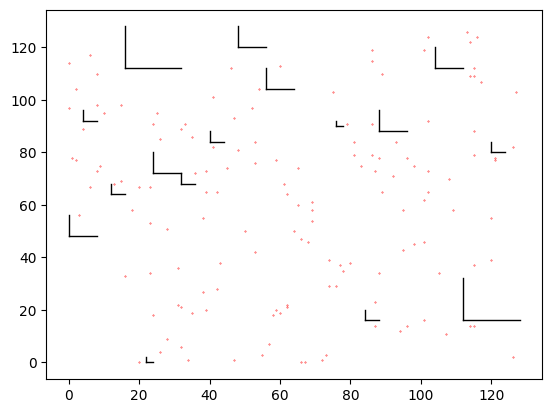

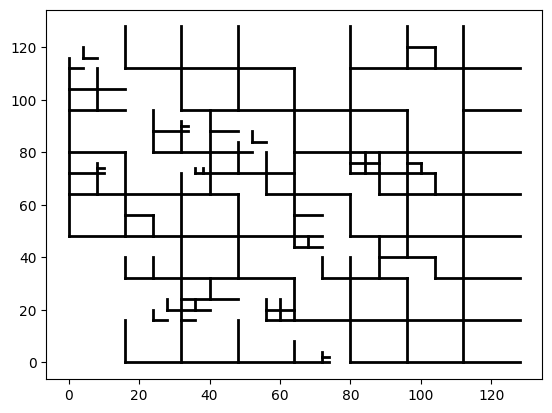

In [116]:
import matplotlib.pyplot as plt
import scipy.sparse as sp

n = 1<<7
epsilon = 0.1
max_rank = 1
density = 0.01


matrix = sparse_matrix(n, n, density)

root = create_tree(matrix, max_rank, epsilon)
wisualize_svd(root, n)
plt.show()
plt.clf()
root = create_tree(matrix, 2, 0.5)
wisualize_svd(root, n)
plt.show()

density:0.01, max_rank:1


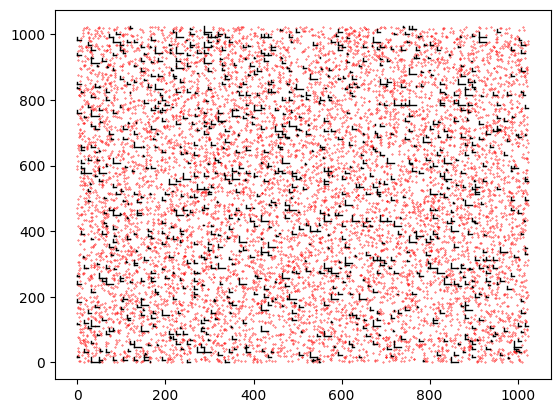

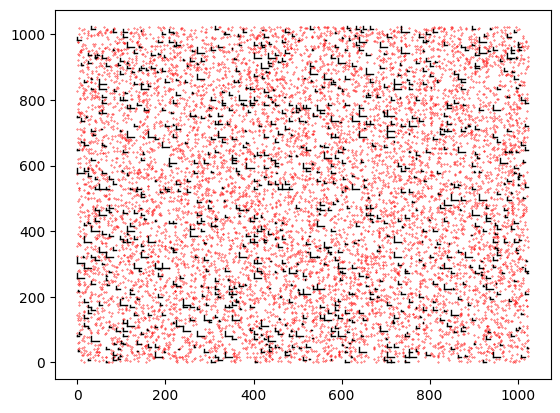

density:0.01, max_rank:4


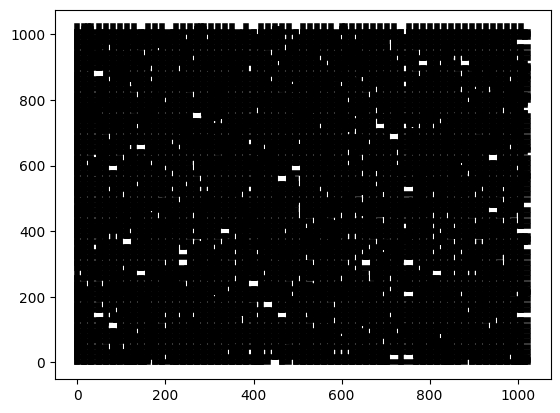

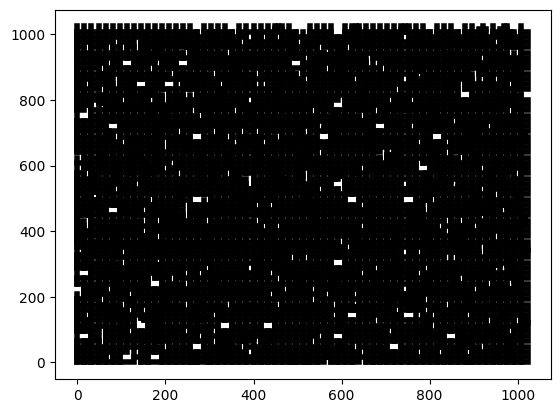

density:0.02, max_rank:1


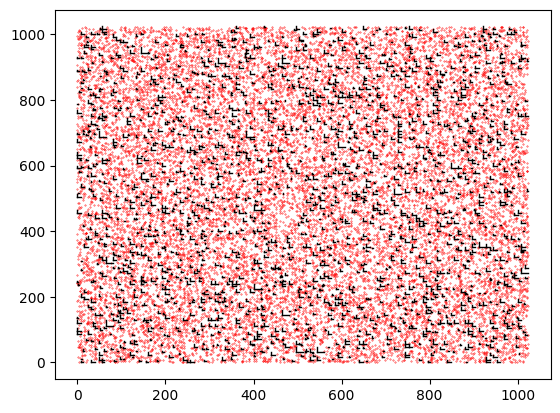

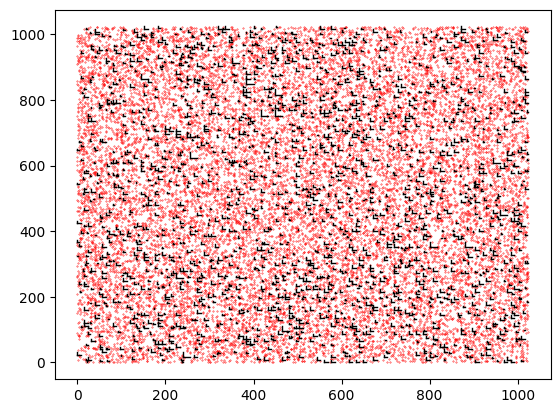

density:0.02, max_rank:4


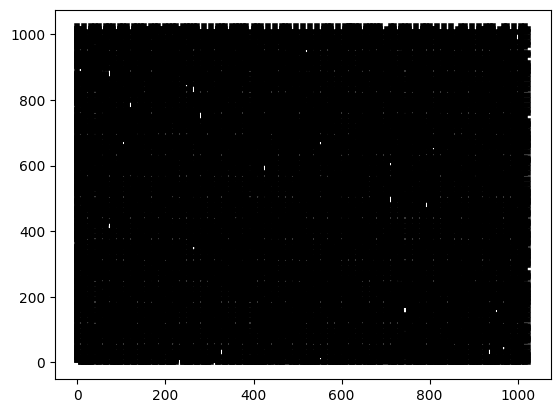

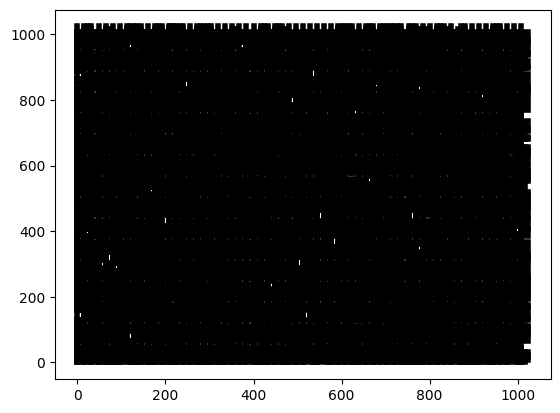

density:0.05, max_rank:1


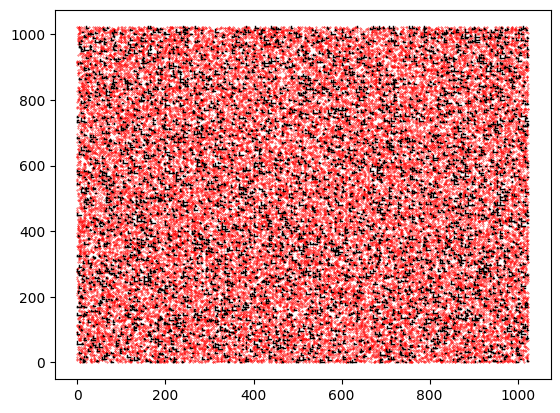

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001C0052C3F60> (for post_execute):


KeyboardInterrupt: 

In [12]:
from time import time
n = 1<<10
epsilon = 0.1
max_rank = 1
density = 0.01
compresions_times = []
S_all = {}
errors = {}
for density in [0.01, 0.02, 0.05, 0.1, 0.2]:
    S_all[density] = {}
    errors[density] = {}
    for rank in [1, 4]:
        print(f"density:{density}, max_rank:{rank}")
        compresions_times.append([])
        S_all[density][rank] = []
        errors[density][rank] = []
        for _ in range(2):
            matrix = sparse_matrix(n,n,density)
            start = time()
            root, S = create_tree_with_s(matrix, rank, epsilon)
            end = time()
            S_all[density][rank].append(S)
            errors[density][rank].append(diff(matrix, decompression(root)))
            compresions_times[-1].append(end-start)
            wisualize_svd(root, n)
            plt.show()
            plt.clf()

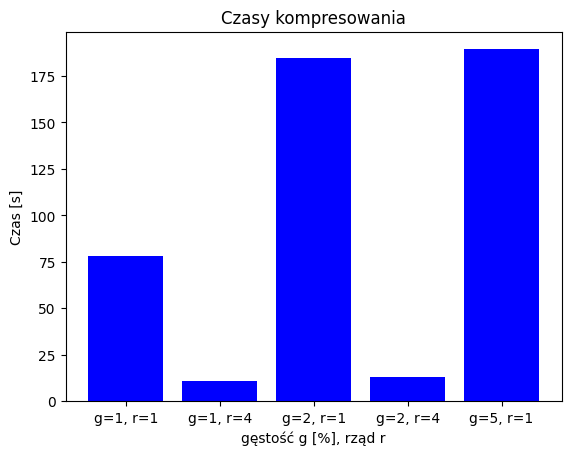

In [21]:
# Dane do wykresu
categories = ['g=1, r=1', 'g=1, r=4', 'g=2, r=1', 'g=2, r=4', "g=5, r=1"]
values = [sum(x)/len(x) for x in compresions_times]

# Tworzenie wykresu słupkowego
plt.bar(categories, values, color='blue')

# Dodanie tytułu i etykiet osi
plt.title('Czasy kompresowania')
plt.xlabel('gęstość g [%], rząd r')
plt.ylabel('Czas [s]')

# Wyświetlenie wykresu
plt.show()


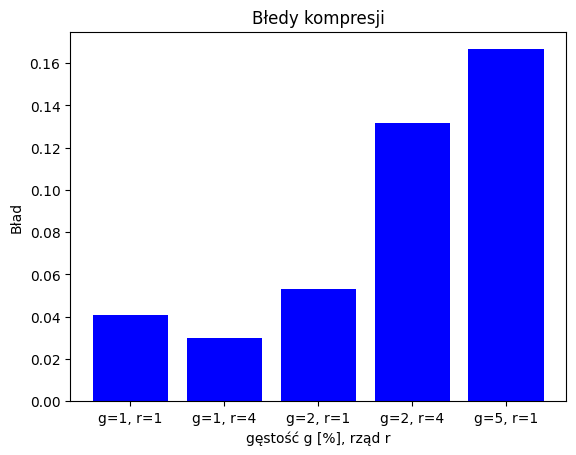

In [32]:
errors2 = [
    [0.05143807828386223, 0.029861089910101845],
    [0.024813419822812845, 0.034632018044548324],
    [0.05933351319878588, 0.04737335724270251],
    [0.12559569744589424, 0.13746174621420146],
    [0.1613831800580513, 0.1718915790734761]
]
# Dane do wykresu
categories = ['g=1, r=1', 'g=1, r=4', 'g=2, r=1', 'g=2, r=4', "g=5, r=1"]
values = [sum(x)/len(x) for x in errors2]

# Tworzenie wykresu słupkowego
plt.bar(categories, values, color='blue')

# Dodanie tytułu i etykiet osi
plt.title('Błedy kompresji')
plt.xlabel('gęstość g [%], rząd r')
plt.ylabel('Bład')

# Wyświetlenie wykresu
plt.show()

In [27]:

errors 

[[0.024813419822812845, 0.034632018044548324],
 [0.12559569744589424, 0.13746174621420146],
 [0.1613831800580513, 0.1718915790734761]]